<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Первичный-анализ-данных" data-toc-modified-id="Первичный-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Первичный анализ данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Токенизация" data-toc-modified-id="Токенизация-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Токенизация</a></span></li><li><span><a href="#Формирование-эмбеддингов" data-toc-modified-id="Формирование-эмбеддингов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Формирование эмбеддингов</a></span></li><li><span><a href="#Сэмплинг" data-toc-modified-id="Сэмплинг-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Сэмплинг</a></span></li></ul></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Моделирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект: «Классификация тональности комментариев с BERT»

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель:**
1. Построить модель классифицикации комментариев на позитивные и негативные.
2. Необходимое значение метрики качества F1 не меньше 0.75.

**Описание данных:**
- `text` — текст комментария
- `toxic` — целевой признак

## Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook
import time

import torch
import transformers
from transformers import logging

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

from transformers import logging

%matplotlib inline
sns.set_style("darkgrid")
logging.set_verbosity_error()
random_seed = 17

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 80.1 MB


In [5]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 0


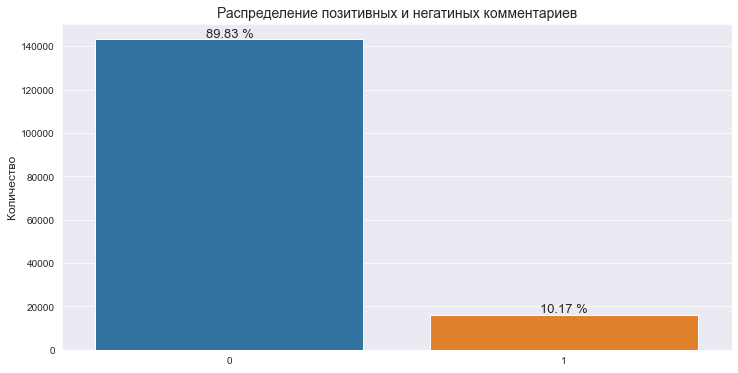

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
ax = sns.countplot(x=df['toxic'])
for i, j in enumerate(df['toxic'].value_counts()):
    ax.text(i, j+1000, 
            f"{round(df['toxic'].value_counts()[i]/df['toxic'].shape[0]*100, 2)} %", 
            horizontalalignment='center', fontsize=13)
    
ax.set_title('Распределение позитивных и негатиных комментариев', fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('Количество', fontsize=12);

**Выводы:**
1. Исследуемый набор данных содержит *159571* комментариев с разметкой о токсичности правок.
2. Обнаружено, что классы несбалансированны. Доля положительного класса с меткой 1 — 0.1017.

## Подготовка данных

### Токенизация

С целью подготовки признаков для бинарной классификации комментариев воспользуемся уже предобученной моделью *DistilBert* для английского языка — distilbert-base-uncased.

In [7]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(
            'distilbert-base-uncased',
            do_lower_case=True)

In [8]:
tokenized = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = len(max(tokenized.values, key=len))
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

### Формирование эмбеддингов

In [9]:
if torch.cuda.is_available():           
    device = torch.device("cuda")    
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')  
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1650


In [10]:
model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', 
                                                      num_labels=2, 
                                                      output_attentions=False, 
                                                      output_hidden_states=False)

model = model.cuda()


batch_size = 50
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    
    torch.cuda.empty_cache()

  0%|          | 0/3191 [00:00<?, ?it/s]

### Сэмплинг

Ребалансировку классов проведем путём уменьшения числа примеров мажоритарного класса (undesampling).

In [11]:
features = pd.DataFrame(np.concatenate(embeddings))
target = df['toxic'][:features.shape[0]]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=random_seed)
print(f'Размер обучающей выборки: {x_train.shape[0]} объектов\nРазмер тестовой выборки: {x_test.shape[0]} объектов')

Размер обучающей выборки: 127640 объектов
Размер тестовой выборки: 31910 объектов


In [12]:
def downsample(features, target, fraction):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=random_seed)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=random_seed)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=random_seed)
    
    return features_downsampled, target_downsampled

In [13]:
x_train, y_train = downsample(x_train, y_train, y_train.mean()*5)
print(f'Размер обучающей выборки после сэмплинга: {x_train.shape[0]} объектов')

Размер обучающей выборки после сэмплинга: 71031 объектов


**Выводы:**
1. Формирование эмбеддингов в качестве признаков для модели бинарной классификации проведено после токенизации с использованием предварительно обученной модели *DistilBERT*.
2. Комментарри имеющие длину токенов, превышающую *512* были обрезаны до данного значения, так как это максимальная длина последовательности для данной модели.
3. Проведен сэмплинг с целью уменьшения числа примеров мажоритарного класса.

## Моделирование

С целью проведения более полного исследования проведем моделирование с использованием следующих алгоритмов классификации: *LogisticRegression*, *LGBMClassifier*, *CatBoostClassifier*. Однако, ввиду ресурсоемкости поставленной задачи откажемся от тюнинга гиперпараметров с помощью GridSearchCV или Optuna.

In [42]:
algoritms = [LogisticRegression(random_state=random_seed, 
                                max_iter=1e5),
             
            LGBMClassifier(random_state=random_seed, 
                           n_estimators=1000,
                           n_jobs=-1),
             
             
            CatBoostClassifier(random_state=random_seed,
                               silent=True,
                               iterations=1000,
                               loss_function='Logloss',
                              )]

In [43]:
results = pd.DataFrame({'Classifier' : [], 
                        'Train F1 score' : [], 
                        'Test F1 score' : [], 
                        'Learning time, s' : [], 
                        'Prediction time, s' : []})
models_features = {}

for algoritm in notebook.tqdm(algoritms):
    model = algoritm
    name = str(model).split(sep='(')[0]
    
    start_learning = time.time()
    model.fit(x_train, y_train)
    train_f1 = f1_score(y_train, model.predict(x_train))
    end_learning = time.time()
    duration_learning = end_learning - start_learning
    
    start_predictions = time.time()
    test_f1 = f1_score(y_test, model.predict(x_test))
    end_predictions = time.time()
    duration_prediction = end_predictions - start_predictions
    
    models_features[name] = model
    results = results.append({'Classifier': name, 
                              'Train F1 score': round(train_f1, 3), 
                              'Test F1 score': round(test_f1, 3),
                              'Learning time, s': round(duration_learning, 3), 
                              'Prediction time, s': round(duration_prediction, 3)}, ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [44]:
results.loc[2, ['Classifier']] = 'CatBoostClassifier'
results.sort_values(by='Test F1 score', ascending=False)

,Classifier,Train F1 score,Test F1 score,"Learning time, s","Prediction time, s"
0,LogisticRegression,0.813,0.753,54.208,0.112
1,LGBMClassifier,1.000,0.741,89.580,0.658
2,CatBoostClassifier,0.922,0.741,126.669,0.312


**Вывод:**
1. Лучшие результаты на тестовой выборке с использованием метрики f1 показала модель *LogisticRegression* с результатом *0.753*.
2. Лучшие результаты по времени обучения и предсказания также показала модель *LogisticRegression* с результатами *54.208 с* и *0.112 с*, соответственно.

## Общий вывод

Перед нами стояла задача построить модель классификации, которая разделит комментарии на позитивные и негативные. В дальнейшем модель будет использоваться, чтобы искать токсичные комментарии и отправлять их на модерацию.

С целью подготовки признаков для бинарной классификации комментариев была использована уже предобученная модель **DistilBERT** для английского языка — *bert base uncased*. Комментарри имеющие длину токенов, превышающую 512 были обрезаны до данного значения, так как это максимальная длина последовательности для данной модели.

Для достижения поставленной цели было изучено и смоделировано 3 алгоритма классификации:

- LogisticRegression;
- LGBMClassifier;
- CatBoostClassifier.

Как правило, все исследуемые алгоритмы показывают себя хуже при классификации в условиях несбалансированности классов. С учетом этого был проведен сэмплинг путём уменьшения числа примеров мажоритарного класса (undesampling).

В качестве метрики оценки производительности использовалась метрика *f1*.

В результате проведенного исследования лучшие результаты *f1* на тестовой выборке показала модель LogisticRegression с результатом *0.753*. Время обучения и предсказания модели составило *54.208 с* и *0.112 с*, соответственно.